In [1]:
# from google.colab import files
# files.upload()
#!unzip test1
!ls

sample_data


# This code is used to download data in google colab

In [2]:
# Load helper file
link = "https://drive.google.com/file/d/1Cn0B9Zr2irUnZcHqODT9IilGHf9fZ61R/view?usp=sharing"

_, id_t = link.split('d/')

id = id_t.split('/')[0]

print ("Loading file ...")

print (id) # Verify that you have everything after '='

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


file_id = id
downloaded = drive.CreateFile({'id':file_id})
downloaded.FetchMetadata(fetch_all=True)
downloaded.GetContentFile(downloaded.metadata['title'])
print ("Completed")



Loading file ...
1Cn0B9Zr2irUnZcHqODT9IilGHf9fZ61R
Completed


In [1]:
#!unzip Cat_Dog_data


In [ ]:
#!unzip Cat_Dog_data


In [ ]:
#!kaggle competitions download -c Cat_Dog_data -p /content/

In [5]:
!ls Cat_Dog_data/

test  train


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Cats and Dogs Classification (Using Convolutionnal Neural Network + Pytorch)

## To perform well on CNN,  we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

# package we need

In [ ]:
import os
import sys
import cv2
import pandas as pd
import random
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim
import torch.nn.functional as F


from torch.utils.data import Dataset

import glob

from PIL import Image

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Load the dataset

In [ ]:
## Write data loaders for training,  and test sets
## Specify appropriate transforms, and batch_sizes
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
input_size =224*224*3
output_size = 2
# define training, valid and test data directories
data_dir = './Cat_Dog_data/'
train_dir = os.path.join(data_dir, 'train/')
#valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

train_transform = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                      transforms.Grayscale(),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.CenterCrop(size=224),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.repeat(3,1,1)),#])
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

# valid_transforms = transforms.Compose([transforms.Resize(256),
#                                     transforms.CenterCrop(size=224),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize([0.485, 0.456, 0.406],
#                                                          [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.Grayscale(),
                                    transforms.ToTensor(),
                                     transforms.Lambda(lambda x: x.repeat(3,1,1)),#])
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])


# train_data = datasets.ImageFolder(train_dir, transform=train_transform)
# #valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
# test_data = datasets.ImageFolder(test_dir, transform=test_transforms)





# Custom Dataloader

In [ ]:
class DatasetLoader(Dataset):
    def __init__(self, path, transform=None):
        self.classes   = os.listdir(path)
        self.path      = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform
        
        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        if self.file_list[idx][0]==2:
          classLabel = self.file_list[idx][0]-1
        else:
          classLabel = self.file_list[idx][0]
        image = Image.open(fileName)
        if self.transform:
            image = self.transform(image)
        return image, classLabel


In [ ]:

train_data = DatasetLoader(train_dir, transform=train_transform)
test_data = DatasetLoader(test_dir, transform=test_transform)

In [97]:
!ls ./Cat_Dog_data/train/

cat  dog


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
   # num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [99]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0])


In [ ]:
#len(next(iter(test_loader))),next(iter(test_loader))

# Data visualization

In [101]:
for batch_idx, (data, target) in enumerate(train_loader):
  print(data.size())
  break

torch.Size([20, 3, 224, 224])


If we just visualise the data that we have loaded we may noticed that the image look too strenge, that is because the images we loaded are normalize.

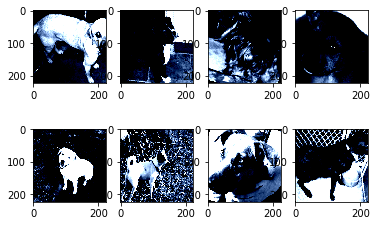

In [102]:
plt.figure()
for i in range(8):
    plt.subplot(2, 4, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy().transpose(1,2,0).clip(0,1))

If we want to see our images in the original format, color,... the we need to denormalize them.
 
To do that we use the following function

In [ ]:

classes = ['cat','dog']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])

def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image
# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img,cmap="gray")

tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1])


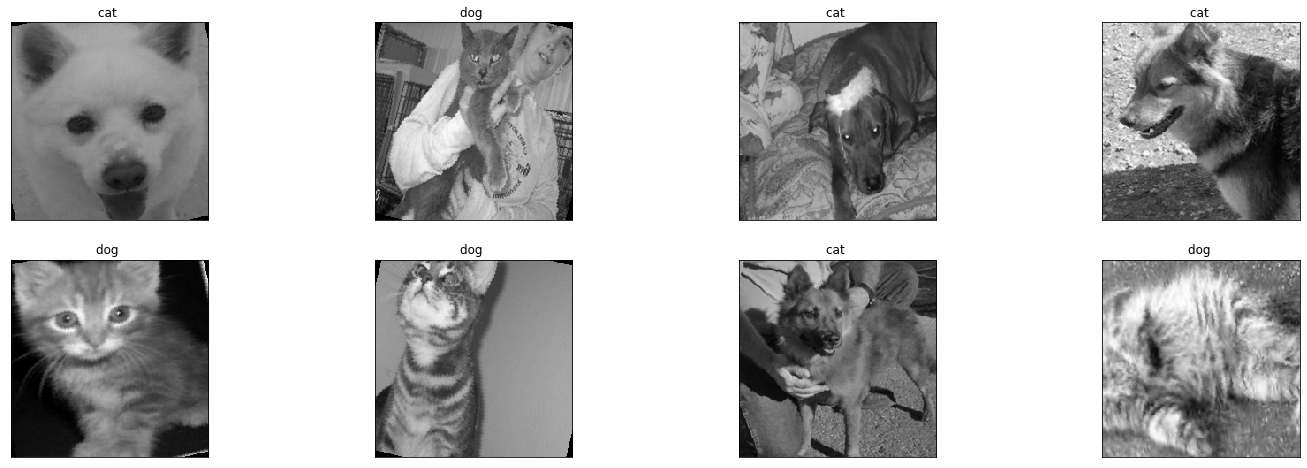

In [106]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 8 images
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ".format(classes[labels[idx]]))

array([0, 1, 2, 3, 4, 5, 6, 7])

# Our model :

Here we want to compare the performance of the fully connected NN and the CNN.

That's why we have to separate model

In [ ]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*53*53, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*53*53)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Train and Test functions

In [ ]:
accuracy_list = []

def train(epoch, model,perm=torch.arange(0, 50176).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #we chage the device if the GPU is available
        if  torch.cuda.is_available():
              data, target = data.cuda(), target.cuda()
        # permute pixels
#         data = data.view(-1, 224*224)
#         data = data[:, perm]
#         data = data.view(-1, 3, 224, 224)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 50176).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
          #we chage the device if the GPU is available
          if  torch.cuda.is_available():
              data, target = data.cuda(), target.cuda()
          
          # permute pixels
          data = data.view(-1, 224*224)
          data = data[:, perm]
          data = data.view(-1, 3, 224, 224)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
          correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Experiment on Fully connected NN :


# Train a small fully-connected network

In [109]:
n_hidden = 6 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size).cuda()
#we change the device if the GPU is available
if  torch.cuda.is_available():
  model_fnn = model_fnn.cuda()
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 903230
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.623227
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.708212
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.639170
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.694815
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.903086
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.601932
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.609789
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.649400
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.686944
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.654190
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.619096
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.675750

Test set: Average loss: 0.6648, Accuracy: 1506/2500 (60%)



In [ ]:
#torch.cuda.is_available()

True

In [ ]:
#device

device(type='cuda', index=0)

# Experiment on CNN

# Train CNN network

In [110]:
# Training settings 
n_features =6 # number of feature maps
model_cnn = CNN(input_size, n_features, output_size)
#we change the device if the GPU is available
if  torch.cuda.is_available():
  model_cnn = model_cnn.cuda()
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 844214
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.697110
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.690578
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.714638
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.677225
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.651224
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.649628
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.639420
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.619608
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.585730
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.580784
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.648340
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.589598

Test set: Average loss: 0.6274, Accuracy: 1615/2500 (65%)



# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?




So let's permut the pixels of our images

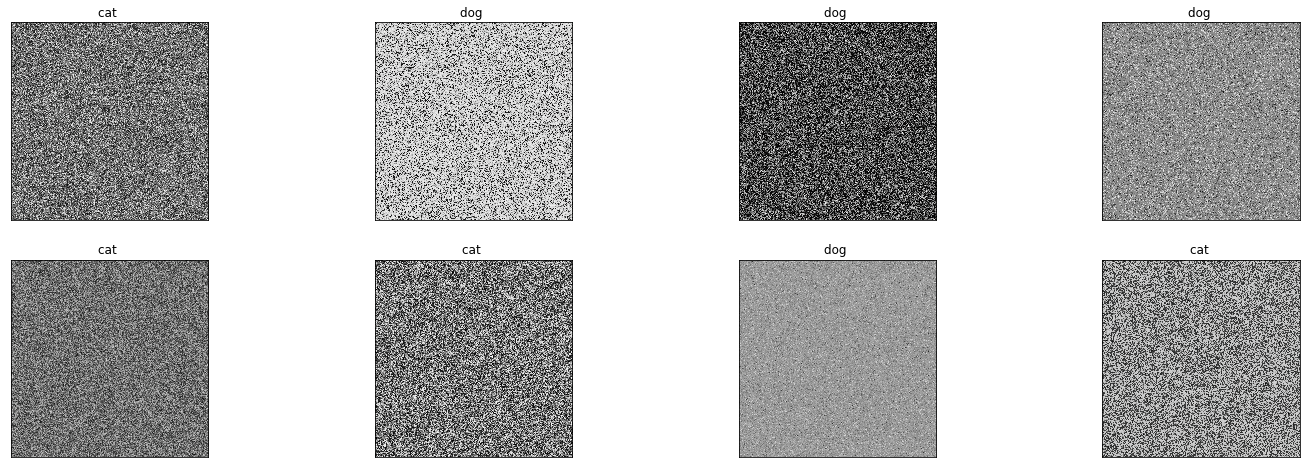

In [111]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# permute pixels
perm = torch.randperm(50176)
image_perm = images.view(-1, 224*224).clone()
image_perm = image_perm[:, perm]
image_perm = image_perm.view(-1, 3, 224, 224)
# plot the image  in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
# display 10 images
for idx in np.arange(8):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    imshow(image_perm[idx])
    ax.set_title("{} ".format( classes[labels[idx]]))

# Fully-Connected with Permuted Pixels

In [112]:
n_hidden = 6    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
#we change the device if the GPU is available
if  torch.cuda.is_available():
  model_fnn = model_fnn.cuda()
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 903230
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.678546
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.687495
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.746874
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.674069
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.749498
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.651797
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.633177
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.672724
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.699644
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.843271
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.636427
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.701003

Test set: Average loss: 0.7074, Accuracy: 1309/2500 (52%)



# ConvNet with permuted pixels

In [113]:
# Training settings 
n_features =6 # number of feature maps
model_cnn = CNN(input_size, n_features, output_size)
#we chage the device if the GPU is available
if  torch.cuda.is_available():
  model_cnn = model_cnn.cuda()
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 844214
Train Epoch: 0 [0/22500 (0%)]	Loss: 0.688111
Train Epoch: 0 [2000/22500 (9%)]	Loss: 0.664188
Train Epoch: 0 [4000/22500 (18%)]	Loss: 0.688014
Train Epoch: 0 [6000/22500 (27%)]	Loss: 0.662174
Train Epoch: 0 [8000/22500 (36%)]	Loss: 0.607426
Train Epoch: 0 [10000/22500 (44%)]	Loss: 0.703134
Train Epoch: 0 [12000/22500 (53%)]	Loss: 0.674525
Train Epoch: 0 [14000/22500 (62%)]	Loss: 0.741602
Train Epoch: 0 [16000/22500 (71%)]	Loss: 0.626065
Train Epoch: 0 [18000/22500 (80%)]	Loss: 0.522314
Train Epoch: 0 [20000/22500 (89%)]	Loss: 0.584084
Train Epoch: 0 [22000/22500 (98%)]	Loss: 0.693306

Test set: Average loss: 1.7479, Accuracy: 1247/2500 (50%)



# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

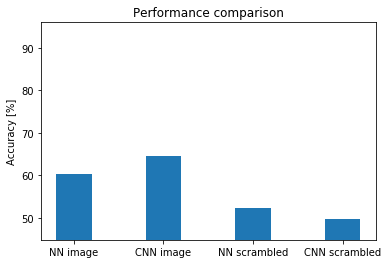

In [114]:
plt.bar(('NN image', 'CNN image','NN scrambled',
         'CNN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title('Performance comparison');

##  particular way to load data without using pytorch 


In [ ]:
input_size  = 100*100  # images are 28x28 pixels
output_size = 2      # there are 10 classes

image_path = './Cat_Dog_data/train/cat'
filenames = os.listdir(image_path)
categories = []
dog = []
cat = []
for filename in filenames:
    file_category = filename.split(".")[0]
    
    if file_category == "dog":
        categories.append(0)
        dog.append(filename)
    else : 
        categories.append(1)
        cat.append(filename)
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head(3)

,filename,category
0,cat.1097.jpg,1
1,cat.10853.jpg,1
2,cat.4388.jpg,1
